<font color='blue'> **gis-utils** </font> 

In [1]:
%%capture
from pathlib import Path ; import numpy as np ; import pandas as pd ; import geopandas as gp ; import rasterio ; import gisutils ; import matplotlib.pyplot as plt
TA=Path("./TA"); TA.mkdir(exist_ok=True); import os   ; from rasterio.plot import show  ; import flopy ; from shapely.geometry import Point  ; import geopandas as gpd ; import earthpy.spatial as es
R1 = Path('E:/15_REPOS/02_Beta-Me/data/gis-utils')    ; SHPS = [os.path.join(R1/'NHDPlus04_flowline.shp'),os.path.join(R1/'NHDPlus07_flowline.shp')]  ; TOPO = os.path.join(R1/'top.tif')
CRS = gisutils.get_shapefile_crs(SHPS[0]) #; print(SHPS[0], 'CRS' ,CRS)    

In [2]:
%%capture
DF1  = gisutils.shp2df(SHPS) ;DF1.to_csv(TA/'BA0_two_shapes.csv')     ; gisutils.df2shp(DF1, 'TA/BA1.shp', crs=4269)  ; DF1.to_csv(TA/'BA0_shp01.csv')
DF2 = gisutils.shp2df(SHPS[1]) ;DF2.to_csv(TA/'BB0_one_shapes.csv')  #; gisutils.df2shp(DF2, 'TA/BB1.shp', crs=4269)  ; DF2.to_csv(TA/'BB1_shp01.csv')                    # ERR
#VEC2 = gpd.read_file(os.path.join(TA/'BB1_shp01.csv'))                  ; VEC2                                           ; OVER2 = VEC2.to_crs(es.crs_check(R1/'top.tif'))    # ERR

gisutils.df2shp(DF1.drop('geometry', axis=1), 'TA/BA1.dbf')             #  ______________________  Write NEW .DBF SHPS _____________________________________ ! ! !

In [3]:
DF2.tail(2)

,COMID,FDATE,RESOLUTION,GNIS_ID,GNIS_NAME,LENGTHKM,REACHCODE,FLOWDIR,WBAREACOMI,FTYPE,FCODE,SHAPE_LENG,ENABLED,GNIS_NBR,geometry
124,14705294,2009-05-01,Medium,1565194,Fourteenmile Creek,0.17,07070003004704,With Digitized,14704068,ArtificialPath,55800,0.002080,True,0,LINESTRING Z (-89.73521170448635 44.2083773980...
125,14705300,2009-05-01,Medium,None,None,0.49,07070003004705,With Digitized,14704068,ArtificialPath,55800,0.005853,True,0,LINESTRING Z (-89.72969510449491 44.2066005313...


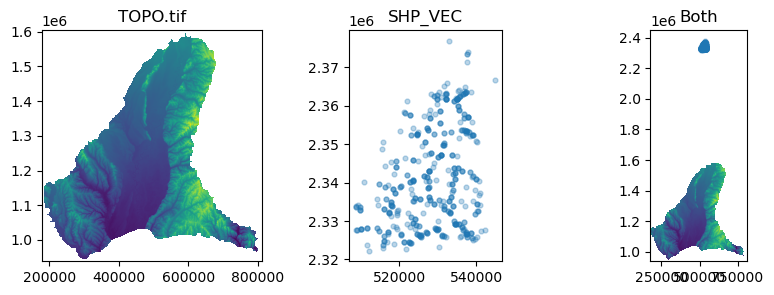

In [4]:
VEC1 = gpd.read_file(SHPS[0])                         ; OVER1 = VEC1.to_crs(es.crs_check(R1/'top.tif'))         ; B0=flopy.utils.Raster.load(TOPO)
fig = plt.figure(figsize=(10,3))     
ax = fig.add_subplot(131)  ; plt.title("TOPO.tif")     ; B0.plot(ax=ax)  
ax = fig.add_subplot(132)  ; plt.title("SHP_VEC")                         ; OVER1.boundary.plot(ax=ax, alpha=0.3,markersize=12)   
ax = fig.add_subplot(133)  ; plt.title("Both")         ; B0.plot(ax=ax)   ; OVER1.boundary.plot(ax=ax, alpha=0.3,markersize=12)   ; plt.show(block=False)

In [5]:
%%capture
T01= rasterio.open(TOPO)    #;show(T01)                         # with rasterio.open(TOPO) as src: show(src)                                  
gisutils.projection.project_raster(TOPO, 'TA/BA2.tif', 4269)    ; gisutils.projection.project_raster(TOPO, 'TA/BA3.tif', 5070,resolution=1e4)  # Reproject & resolution

NN=100 ; MM = 10000         # 700 | 1000     
nrow,ncol =NN,NN   ;x=np.arange(ncol)*MM+177955.0 ;y=1604285.0-(np.arange(nrow)*MM)[::-1]     ; X,Y = np.meshgrid(x, y)                         
SAMPLED = gisutils.get_values_at_points(TOPO, x=X.ravel(), y=Y.ravel(),points_crs=None)       ; SAMPLED = np.reshape(SAMPLED, (nrow, ncol)) 
pd.DataFrame(SAMPLED).to_csv (TA/"BA4_SAMPLED.csv")                                           

ST=10;GE=[Point(x, y) for x, y in zip(X[::ST].ravel(),Y[::ST].ravel())]    ;df=gp.GeoDataFrame({'geometry':GE,'elevation':SAMPLED[::ST].ravel()},crs=5070)   ;df.to_file('TA/BA5_Pts_RASTER.shp')
gisutils.raster.points_to_raster('TA/BA5_Pts_RASTER.shp',data_col='elevation',output_resolution=1000,outfile=TA/'PTS_2_RASTER.tif')

In [6]:
pd.DataFrame(GE).tail(2)

,0
998,POINT (1157955 1514285)
999,POINT (1167955 1514285)


In [7]:
with rasterio.open(TOPO) as SRC:       AR = SRC.read(1)       # SRC=rasterio.open(TOPO).read(1)                                            # ARRAY LOWER LEFT CORNER ______________
XLL = SRC.transform[2]               ; YLL = SRC.transform[5] + SRC.height * SRC.transform[4]                                              ; print(XLL, YLL)
n='n'; gisutils.raster.write_raster('TA/BA7_surface.tif', AR   , xll=XLL, yll=YLL,dx=1000, dy=1000, rotation=0, nodata=-9999,CRS = 5070)   # MASK = np.ma.masked_array(AR, AR==-9999) # OR
#      gisutils.raster.write_raster('TA/BA8_surface.tif', MASK , xll=XLL, yll=YLL,dx=1000, dy=1000, rotation=0              ,CRS = 5070)

177955.0 938285.0
wrote TA/BA7_surface.tif


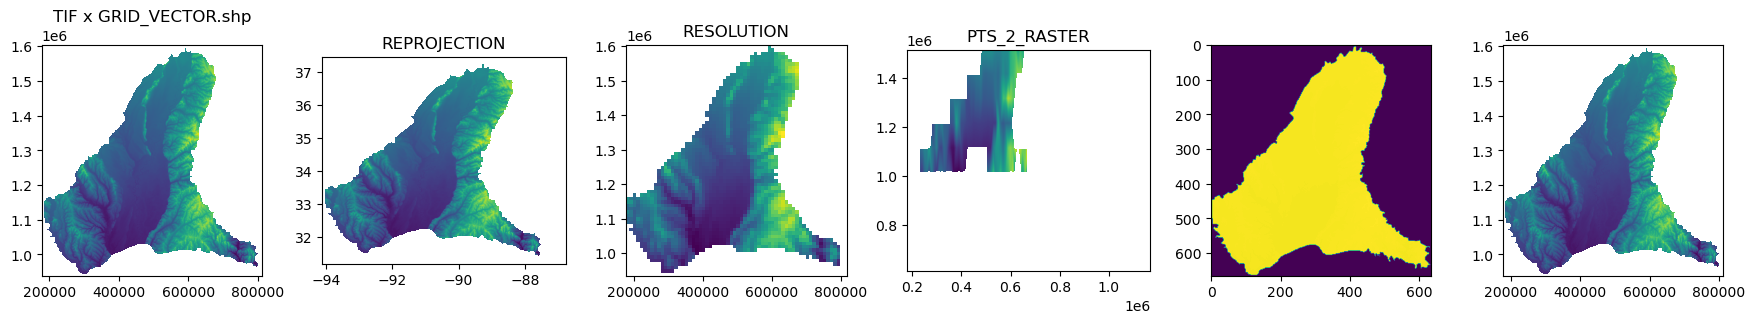

In [8]:
fig = plt.figure(figsize=(22,3))
B0=flopy.utils.Raster.load(TOPO)                    ; ax = fig.add_subplot(161)     ; B0.plot(ax=ax)                                ; plt.title("TIF x GRID_VECTOR.shp")
B1=flopy.utils.Raster.load(TA/'BA2.tif')            ; ax = fig.add_subplot(162)     ; B1.plot(ax=ax)                                ; plt.title("REPROJECTION")
B2=flopy.utils.Raster.load(TA/'BA3.tif')            ; ax = fig.add_subplot(163)     ; B2.plot(ax=ax)                                ; plt.title("RESOLUTION")
B3=flopy.utils.Raster.load(TA/'PTS_2_RASTER.tif')   ; ax = fig.add_subplot(164)     ; B3.plot(ax=ax)                                ; plt.title("PTS_2_RASTER")
n='n'                                               ; ax = fig.add_subplot(165)     ; plt.imshow(rasterio.open(TOPO).read(1))     
B4=flopy.utils.Raster.load(TA/'BA8_surface.tif')    ; ax = fig.add_subplot(166)     ; B4.plot(ax=ax)       ; plt.show(block=False)    

<font color='orange'> **__________________________________________________________________________________________________________________________** </font> 

**One** [`pyproj.CRS`](https://pyproj4.github.io/pyproj/stable/examples.html#using-CRS) 
**Other** [Not recommended anymore](https://pyproj4.github.io/pyproj/stable/gotchas.html#what-is-the-best-format-to-store-the-CRS-information)
**Then** [spatialreference.org lists at least 3](https://spatialreference.org/ref/epsg/3070/)
**So** (as a [``pyproj.CRS``](https://pyproj4.github.io/pyproj/stable/api/CRS/CRS.html) instance)

In [9]:
proj_str_3070 = (('+proj=tmerc +lat_0=0 +lon_0=-90 +k=0.9996 ''+x_0=520000 +y_0=-4480000 +ellps=GRS80 ''+datum=NAD83  +units=m +no_defs'))
#CRS_3070 = gisutils.get_authority_crs(proj_str_3070)    ; CRS_3070
CRS_3070 = gisutils.get_authority_crs(3070) # ==
wkt_3070 = ('PROJCS["NAD83 / Wisconsin Transverse Mercator",'   'GEOGCS["GCS_North_American_1983",'     'DATUM["D_North_American_1983",'
            'SPHEROID["GRS_1980",6378137,298.257222101]],'      'PRIMEM["Greenwich",0],'                'UNIT["Degree",0.017453292519943295]],'
            'PROJECTION["Transverse_Mercator"],'                'PARAMETER["latitude_of_origin",0],'    'PARAMETER["central_meridian",-90],'
            'PARAMETER["scale_factor",0.9996],'                 'PARAMETER["false_easting",520000],'    'PARAMETER["false_northing",-4480000],'     'UNIT["Meter",1]]')   #;CRS_3070
print(gisutils.raster.get_raster_crs(TOPO))  ; CRS_3070 == gisutils.get_authority_crs(wkt_3070)

EPSG:5070


True

In [10]:
x5070, y5070 = gisutils.project((-91.87370, 34.93738), CRS, 5070)    ; print(int(x5070), int(y5070),'__________'          , gisutils.project((x5070, y5070), 5070, CRS))
x, y = DF1.geometry.values[0].coords.xy                                                                                  ; print(x, y) #; df.geometry.values[0]
x, y = DF1.geometry.values[0].coords.xy                             ; x3070,y3070 = gisutils.project((x, y), 4269, 3070) ; print(x3070, y3070)

print('CRS' ,CRS) 
geom_3070 = gisutils.project(DF1.geometry.values[0], 4269, 3070)     ; geom_4269 = gisutils.project(geom_3070, 3070, 4269)       # shapley geometry object
geom_4269.equals_exact(DF1.geometry.values[0], tolerance=0.0001)     # geom_4269.almost_equals(DF1.geometry.values[0])

373687 1327908 __________ (-91.8737, 34.937380000000005)
array('d', [-89.26039797189003, -89.2579247052272, -89.25621370522987, -89.25458977189902, -89.25401490523325, -89.25257830523549, -89.25215330523616, -89.25117910523767, -89.25032990523897, -89.24854390524177, -89.24863097190831, -89.24822310524223, -89.2481227719091]) array('d', [44.03200613165353, 44.03036993165608, 44.02990519832349, 44.028563798325536, 44.02727593166088, 44.02581819832983, 44.02478959833144, 44.02398473166602, 44.02368973166648, 44.022214198335405, 44.0213375983368, 44.02089139833748, 44.02087259833752])
array('d', [579265.1077264423, 579464.9296831822, 579602.5037546933, 579733.9833919932, 579781.3452866407, 579897.9389532936, 579933.0346628772, 580011.9199958814, 580080.2745762386, 580224.9028089752, 580218.8122406754, 580251.9528742861, 580260.0132546861]) array('d', [395693.57724608574, 395513.6278105201, 395463.2462046379, 395315.4341270579, 395172.8092087172, 395011.9435474267, 394898.0072433781, 39480

True

In [11]:
#R0=Path('E:/15_REPOS/02_Beta-Me/data/sfrmaker/tylerforks')      ; R5   = (R0/'NHDPlus/NHDSnapshot/Hydrography')        # SFRmaker_tylerforks
#VEC6 = gpd.read_file(os.path.join(R5/'NHDFlowline.shp'))        ; OVER6=VEC6.to_crs(es.crs_check(R1/'top.tif'))